In [ ]:
# if (!require("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")

# BiocManager::install("pcaMethods")

In [1]:
Output = '/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1015. Fire Sufficient Similarity/P1015.3. Analyses/P1015.3.3. Cluster Analysis/Output'
cur_date = '032225'

library(readxl)
library(tidyverse)
library(reshape2)
library(factoextra)
library(pcaMethods)
library(gridExtra)
library(ggrepel)
library(cowplot)
library(pheatmap)

# reading in file
full_df = data.frame(read_excel("Input/Processed_Data_032225.xlsx"))

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setd

In [2]:
head(full_df)

,HAWC_ID,Metric,Data,Study,Chemical_Class,DTXSID,Name,Value
,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,266980,Volume,WS,Stockfelt et al. 2012,Metal,K,K,9250.0000
2,266980,Volume,WS,Stockfelt et al. 2012,Metal,Ca,Ca,186558.2941
3,266980,Volume,WS,Stockfelt et al. 2012,Metal,Cd,Cd,2318.1878
4,266980,Volume,WS,Stockfelt et al. 2012,Metal,Fe,Fe,21443.6190
5,266980,Volume,WS,Stockfelt et al. 2012,Metal,Mn,Mn,10704.7944
6,266980,Volume,WS,Stockfelt et al. 2012,Metal,Co,Co,203.2304


In [3]:
split_df = full_df %>%
    select(-Name) %>%
    group_by(Metric, Chemical_Class) %>%
    group_split

metal_vol_df = split_df[[1]]
pah_vol_df = split_df[[2]]
voc_vol_df = split_df[[3]]
metal_weight_df = split_df[[4]]
#pah_weight_df = split_df[[5]]

head(metal_vol_df)

HAWC_ID,Metric,Data,Study,Chemical_Class,DTXSID,Value
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
266980,Volume,WS,Stockfelt et al. 2012,Metal,K,9250.0000
266980,Volume,WS,Stockfelt et al. 2012,Metal,Ca,186558.2941
266980,Volume,WS,Stockfelt et al. 2012,Metal,Cd,2318.1878
266980,Volume,WS,Stockfelt et al. 2012,Metal,Fe,21443.6190
266980,Volume,WS,Stockfelt et al. 2012,Metal,Mn,10704.7944
266980,Volume,WS,Stockfelt et al. 2012,Metal,Co,203.2304


In [4]:
# casting wide
wider_metal_vol_df = metal_vol_df %>%
    # creating sample ids
    unite("SampleID", c(colnames(metal_vol_df)[c(1,3,5)]), remove = FALSE) %>%
    pivot_wider(names_from = "DTXSID", values_from = "Value") %>%
    column_to_rownames(var = "SampleID")
wider_pah_vol_df = pah_vol_df %>%
    unite("SampleID", c(colnames(pah_vol_df)[c(1,3,5)]), remove = FALSE) %>%
    pivot_wider(names_from = "DTXSID", values_from = "Value") %>%
    column_to_rownames(var = "SampleID")
wider_voc_vol_df = voc_vol_df %>%
    unite("SampleID", c(colnames(voc_vol_df)[c(1,3,5)]), remove = FALSE) %>%
    pivot_wider(names_from = "DTXSID", values_from = "Value") %>%
    column_to_rownames(var = "SampleID")

wider_metal_weight_df = metal_weight_df %>%
    unite("SampleID", c(colnames(metal_weight_df)[c(1,3,5)]), remove = FALSE) %>%
    pivot_wider(names_from = "DTXSID", values_from = "Value") %>%
    column_to_rownames(var = "SampleID")
# wider_metal_vol_df = volume_df %>%
#     filter(Chemical_Class == 'Metal') %>%
#     # creating sample ids
#     unite("SampleID", c(colnames(volume_df)[c(1,8,6,5)]), remove = FALSE) %>%
#     pivot_wider(names_from = "DTXSID", values_from = "Value") #%>%
#     #column_to_rownames(var = "SampleID")


head(wider_metal_vol_df)

,HAWC_ID,Metric,Data,Study,Chemical_Class,K,Ca,Cd,Fe,Mn,Co,Ni,Sr
,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
266980_WS_Metal,266980,Volume,WS,Stockfelt et al. 2012,Metal,9250.00,186558.29,2318.188,21443.619,10704.79,203.2304,797.0019,1475.19462
266987_WS_Metal,266987,Volume,WS,Seagrave 2005,Metal,763600.00,49200.00,3500.000,52600.000,1800.00,266.2934,1908.7912,1183.71135
452289_WS_Metal,452289,Volume,WS,Rabha 2018,Metal,51992.69,15793.76,30.000,2060.389,290.00,30.0000,170.0000,72.83742
885041_WS_Metal,885041,Volume,WS,Ihantola et al. 2020,Metal,99550.00,3710.00,152.000,1088.500,133.00,0.9350,25.7500,12.25500
993956_WS_Metal,993956,Volume,WS,Ihantola et al. 2022,Metal,60000.00,2800.00,25.000,1400.000,280.00,1.6000,47.0000,20.00000
1263480_WS_Metal,1263480,Volume,WS,Burnet et al. 1990,Metal,1593166.67,374250.00,1833.333,25791.667,11708.33,272.8643,1375.0000,6583.33333


This analysis will use PCA to explore if chemical and metal concentrations of wildfire and woodsmoke samples are similar using PCA.

# Principal Component Analysis (PCA)

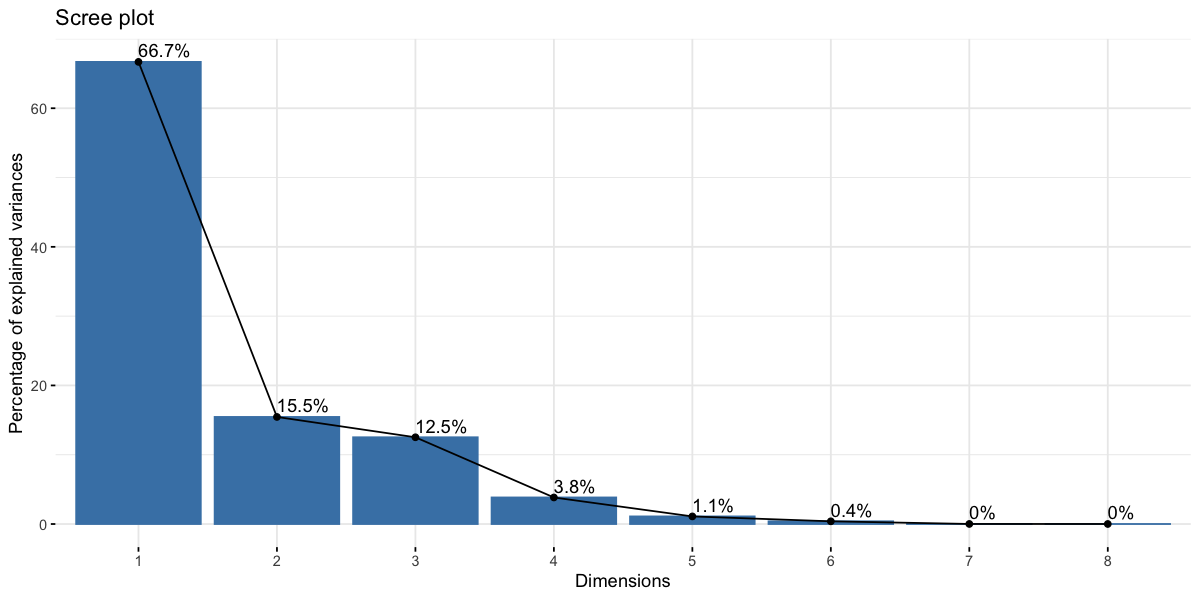

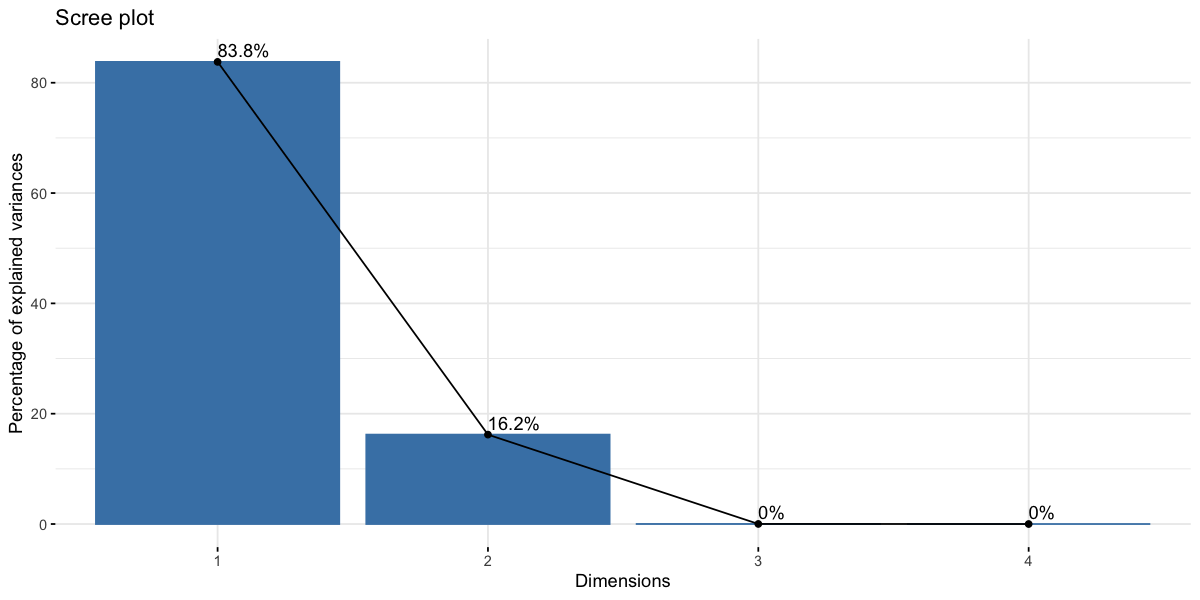

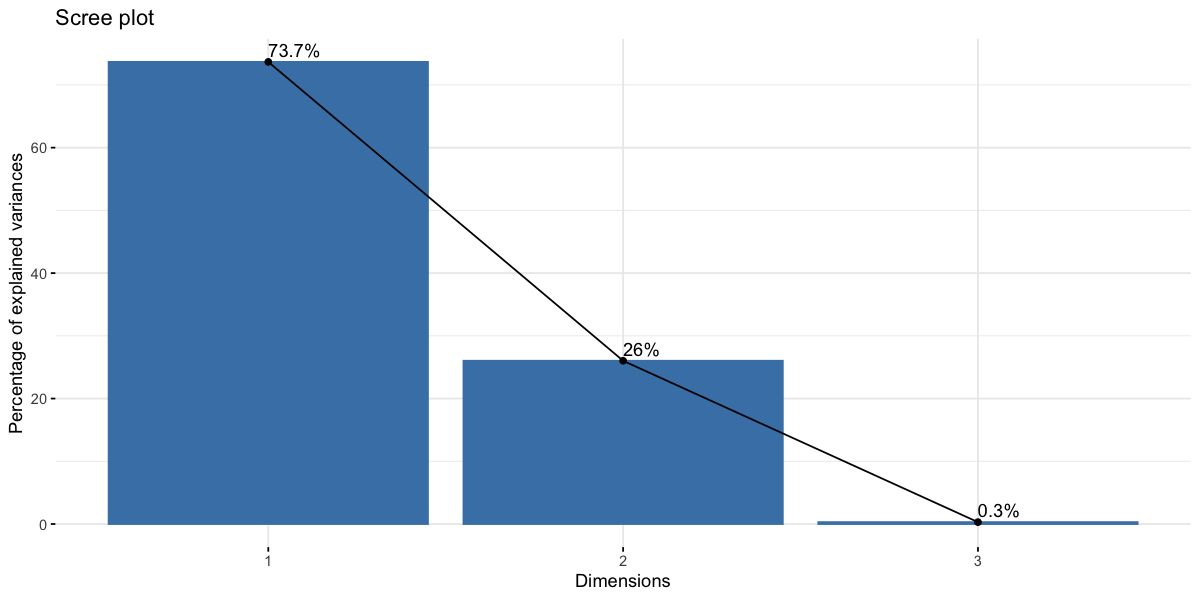

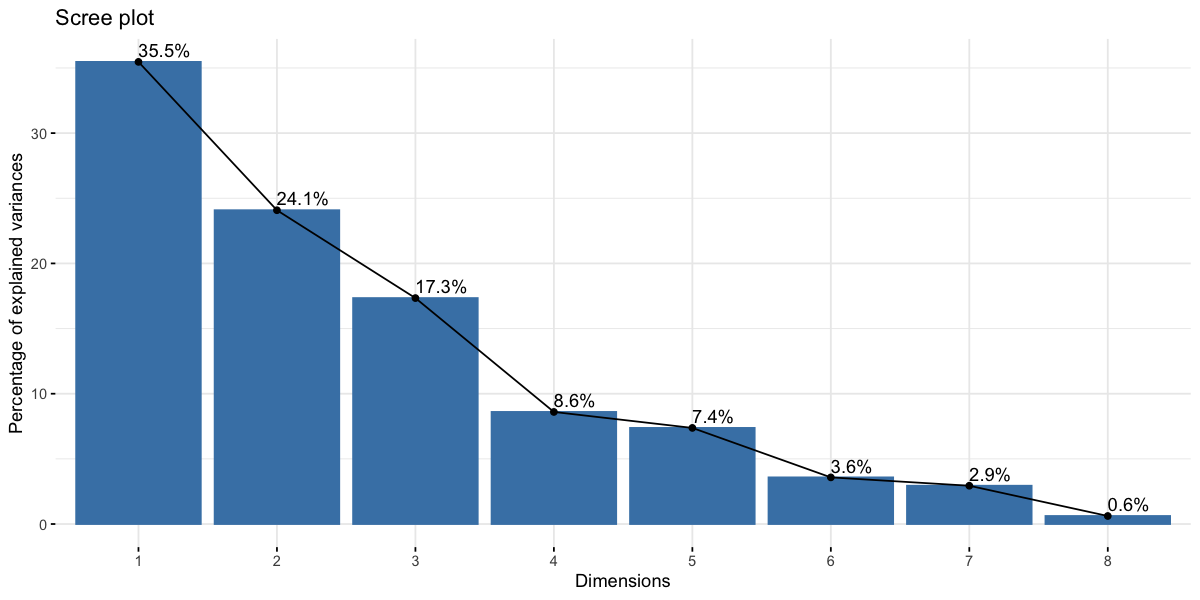

In [5]:
# running pca 
metal_vol_pca = prcomp(wider_metal_vol_df[,c(6:ncol(wider_metal_vol_df))], center = TRUE, scale = TRUE)
pah_vol_pca = prcomp(wider_pah_vol_df[,c(6:ncol(wider_pah_vol_df))], center = TRUE, scale = TRUE)
voc_vol_pca = prcomp(wider_voc_vol_df[,c(6:ncol(wider_voc_vol_df))], center = TRUE, scale = TRUE)
metal_weight_pca = prcomp(wider_metal_weight_df[,c(6:ncol(wider_metal_weight_df))], center = TRUE, scale = TRUE)

# looking at a scree plot to see how much of the variance was captured in the first 2 eigenvectors
options(repr.plot.width = 10, repr.plot.height = 5) #changing size
fviz_eig(metal_vol_pca, addlabels = TRUE)
fviz_eig(pah_vol_pca, addlabels = TRUE)
fviz_eig(voc_vol_pca, addlabels = TRUE)
fviz_eig(metal_weight_pca, addlabels = TRUE)
#fviz_eig(cytokine_pca, addlabels = TRUE)

The standard way to detect outliers in genetics is the criterion of being “more than 6 standard deviations away from the mean”. [source](https://privefl.github.io/blog/detecting-outlier-samples-in-pca/)

In [6]:
outlier_detection = function(pca_df){
    # """
    # Creating a scoring function for to detect PCA sample outliers. 
    # :param (input): PCA df (df)
    # :output: outlier names
    # """
    
    # getting scores
    scores = pca_df$x
    # identifying samples that are > 6 standard deviations away from the mean
    outlier_indices = apply(scores, 2, function(x) which( abs(x - mean(x)) > (6 * sd(x)) )) %>%
        Reduce(union, .)
    # getting sample names
    outliers = rownames(scores)[outlier_indices]
    
    return(outliers)
}

# calling fn
metal_vol_outliers = outlier_detection(metal_vol_pca)
pah_vol_outliers = outlier_detection(pah_vol_pca)
voc_vol_outliers = outlier_detection(voc_vol_pca) 
metal_weight_outliers = outlier_detection(metal_weight_pca) 

In [7]:
# getting length
length(metal_vol_outliers)
length(pah_vol_outliers)
length(voc_vol_outliers)
length(metal_weight_outliers)

[1] 0

[1] 0

[1] 0

[1] 0

There were no outliers.

In [8]:
# creating 1 df with eigenvectors, normalized values, condensate, burn condition data??
metal_vol_pca_df = data.frame(metal_vol_pca$x[,1:2]) %>%
               rownames_to_column(var = "SampleID")
pah_vol_pca_df = data.frame(pah_vol_pca$x[,1:2]) %>%
               rownames_to_column(var = "SampleID")
voc_vol_pca_df = data.frame(voc_vol_pca$x[,1:2]) %>%
               rownames_to_column(var = "SampleID")
metal_weight_pca_df = data.frame(metal_weight_pca$x[,1:2]) %>%
               rownames_to_column(var = "SampleID")  

more_data_df = rbind(wider_metal_vol_df[,1:5] %>% 
                                    rownames_to_column(var = "SampleID"), 
                         wider_pah_vol_df[,1:5] %>% 
                                    rownames_to_column(var = "SampleID"), 
                         wider_voc_vol_df[,1:5] %>% 
                                    rownames_to_column(var = "SampleID"), 
                         wider_metal_weight_df[,1:5] %>% 
                                    rownames_to_column(var = "SampleID")) 

full_eigenvector_df = inner_join(rbind(metal_vol_pca_df, pah_vol_pca_df,
                                       voc_vol_pca_df, metal_weight_pca_df), 
                                             more_data_df)

head(full_eigenvector_df)

Joining with `by = join_by(SampleID)`


,SampleID,PC1,PC2,HAWC_ID,Metric,Data,Study,Chemical_Class
,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,266980_WS_Metal,0.7155568,-0.44968977,266980,Volume,WS,Stockfelt et al. 2012,Metal
2,266987_WS_Metal,1.7854916,1.47249168,266987,Volume,WS,Seagrave 2005,Metal
3,452289_WS_Metal,-1.8759219,0.02687066,452289,Volume,WS,Rabha 2018,Metal
4,885041_WS_Metal,-1.9879675,0.08097707,885041,Volume,WS,Ihantola et al. 2020,Metal
5,993956_WS_Metal,-2.0260762,0.05501304,993956,Volume,WS,Ihantola et al. 2022,Metal
6,1263480_WS_Metal,3.0072965,-2.25320129,1263480,Volume,WS,Burnet et al. 1990,Metal


In [9]:
options(repr.plot.width=10, repr.plot.height=7) #changing size
vol1 = ggplot(data = full_eigenvector_df %>%
           filter(Metric == 'Volume', Chemical_Class == 'Metal'), 
       aes(x = PC1, y = PC2, color = Data, shape = Data)) + 
  geom_point(size = 4, position = position_jitter(w = 0.2, h = 0.2), alpha = 1) + 
  #geom_text_repel(aes(label = SampleID), size = 5) + 

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 
  labs(x = 'Dimension 1 (66.7%)', y = 'Dimension 2 (15.5%)') #+ #changing axis labels 

  # scale_color_manual(values = c('#cb181d','#fb6a4a', # cardboard flaming
  #                            "#b56800", "#f09900", # cardboard smoldering
  #                            "#4d4d4d", "#808080", # controls
  #                             '#0000c1','#7f52ff', # cardboard flaming
  #                            "#005200", "#3aa22b")) # cardboard smoldering  

In [10]:
vol2 = ggplot(data = full_eigenvector_df %>%
           filter(Metric == 'Volume', Chemical_Class == 'PAH'), 
       aes(x = PC1, y = PC2, color = Data, shape = Data)) + 
  geom_point(size = 4, position = position_jitter(w = 0.2, h = 0.2), alpha = 1) + 

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 
  labs(x = 'Dimension 1 (83.8%)', y = 'Dimension 2 (26.0%)') #changing axis labels 

In [11]:
vol3 = ggplot(data = full_eigenvector_df %>%
           filter(Metric == 'Volume', Chemical_Class == 'VOC'), 
       aes(x = PC1, y = PC2, color = Data, shape = Data)) + 
  geom_point(size = 4, position = position_jitter(w = 0.2, h = 0.2), alpha = 1) + 

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 
  labs(x = 'Dimension 1 (73.7%)', y = 'Dimension 2 (16.2%)') #changing axis labels 

## Volume PCA Plot

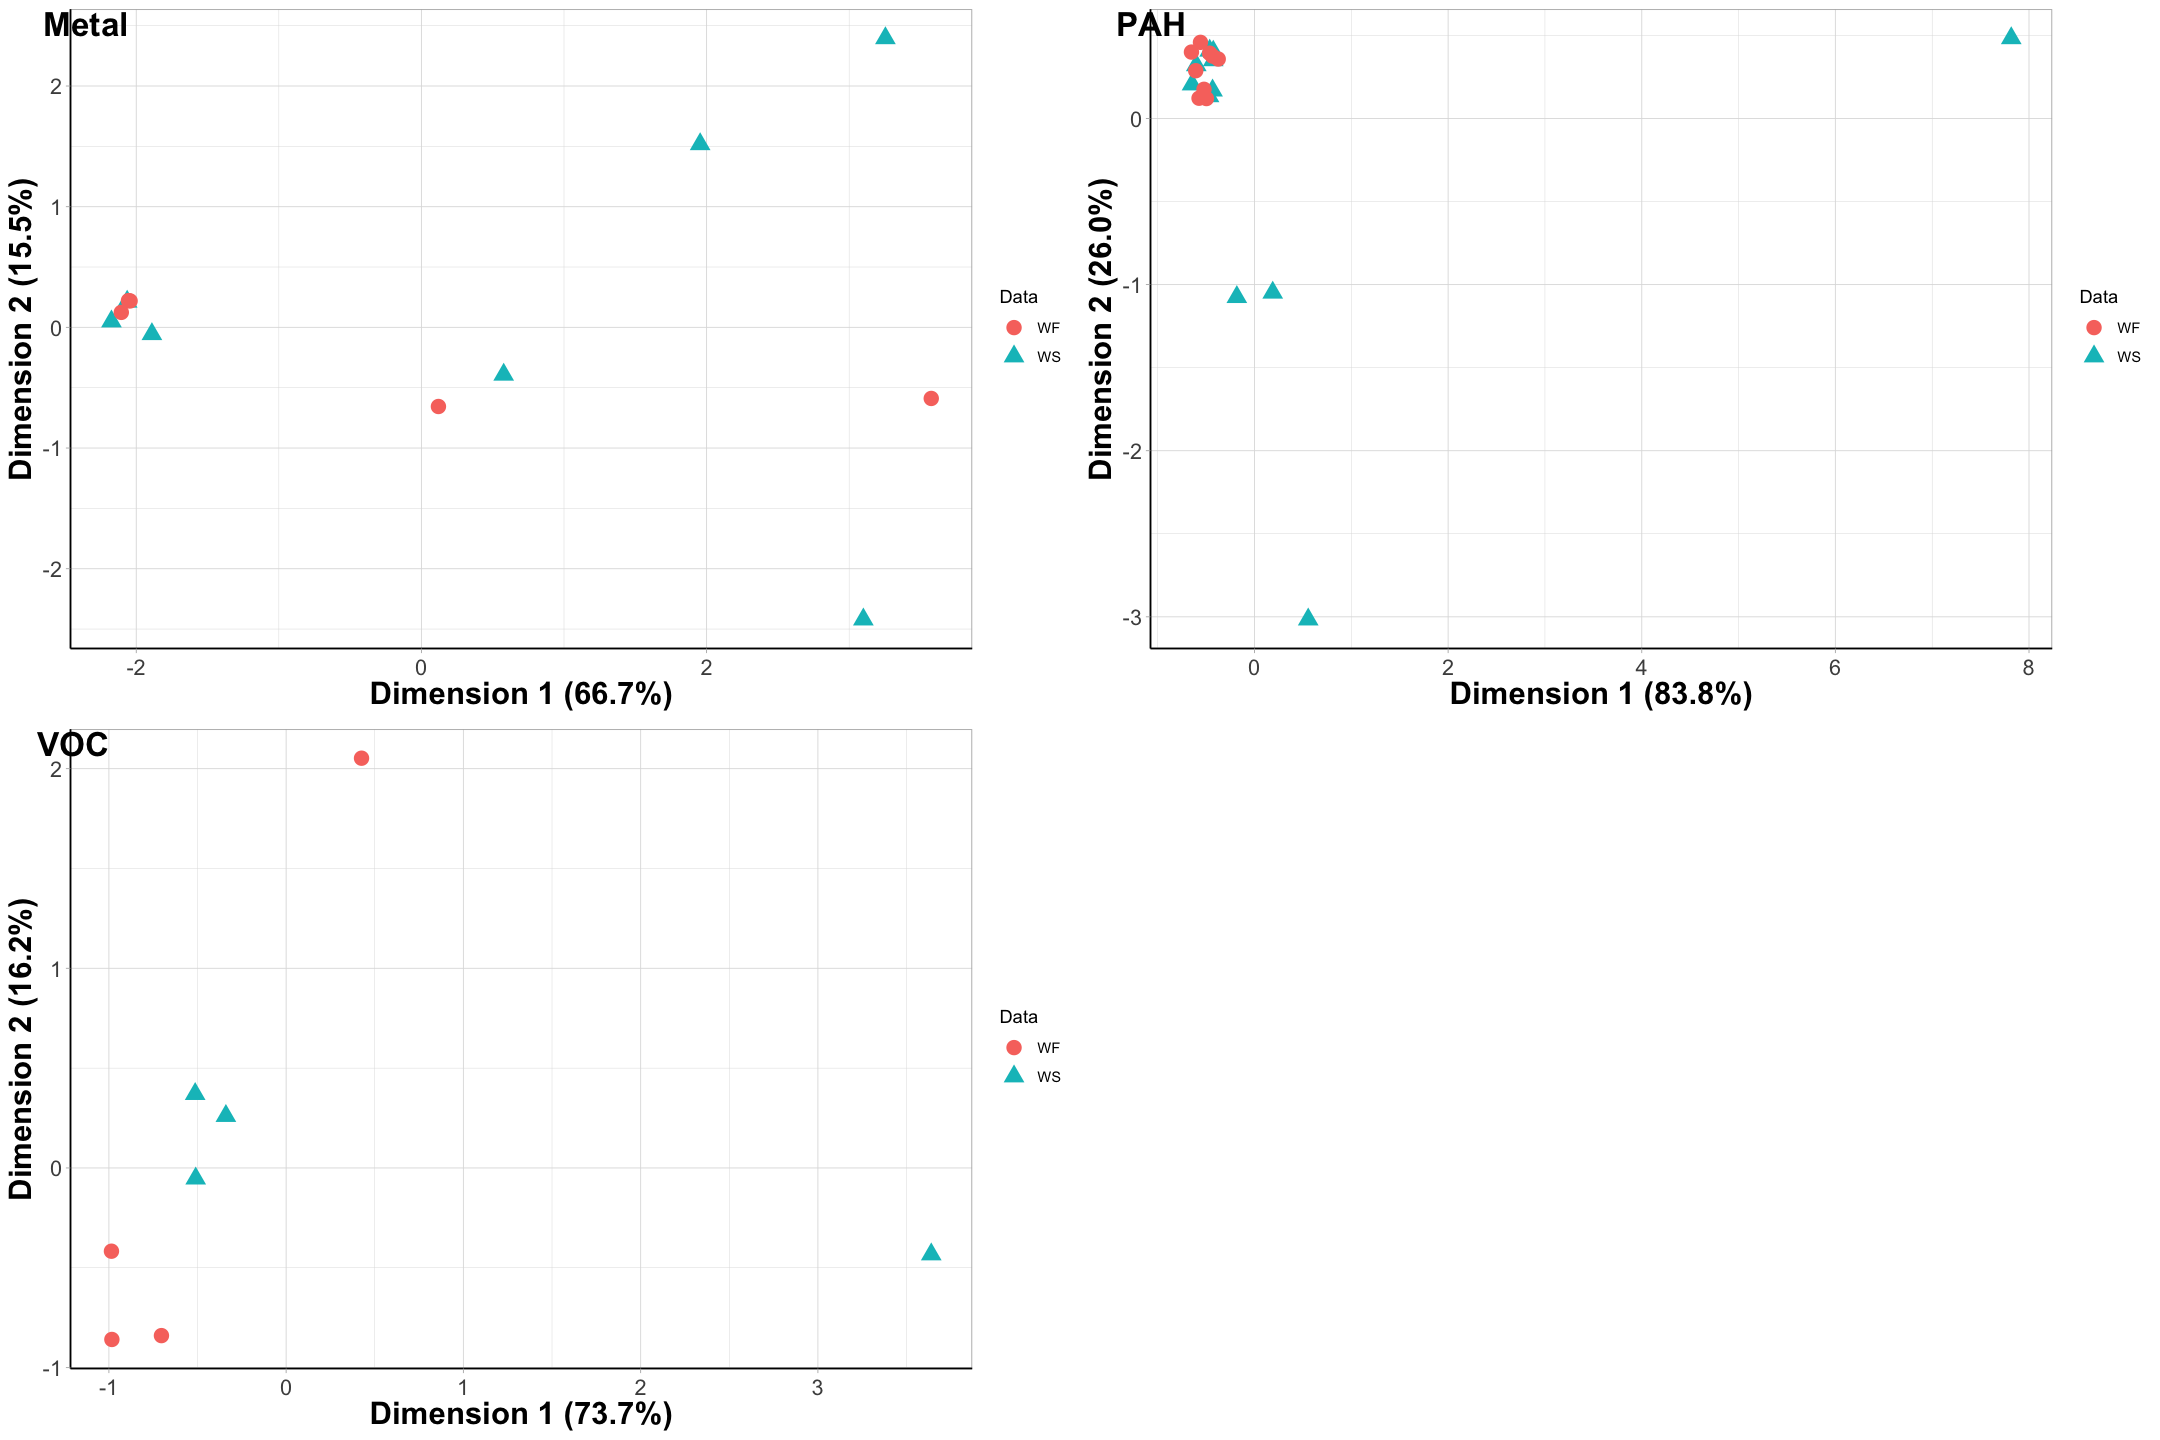

In [30]:
options(repr.plot.width=18, repr.plot.height=12) #changing size
vol_fig = plot_grid(vol1, vol2, vol3, nrow = 2,
                            # adding labels, changing size their size and position
                            labels = c('Metal','PAH','VOC'), label_size = 20, label_x = 0.001, label_y = 1)
vol_fig

## All Volume PCA Plot

## Weight PCA Plot

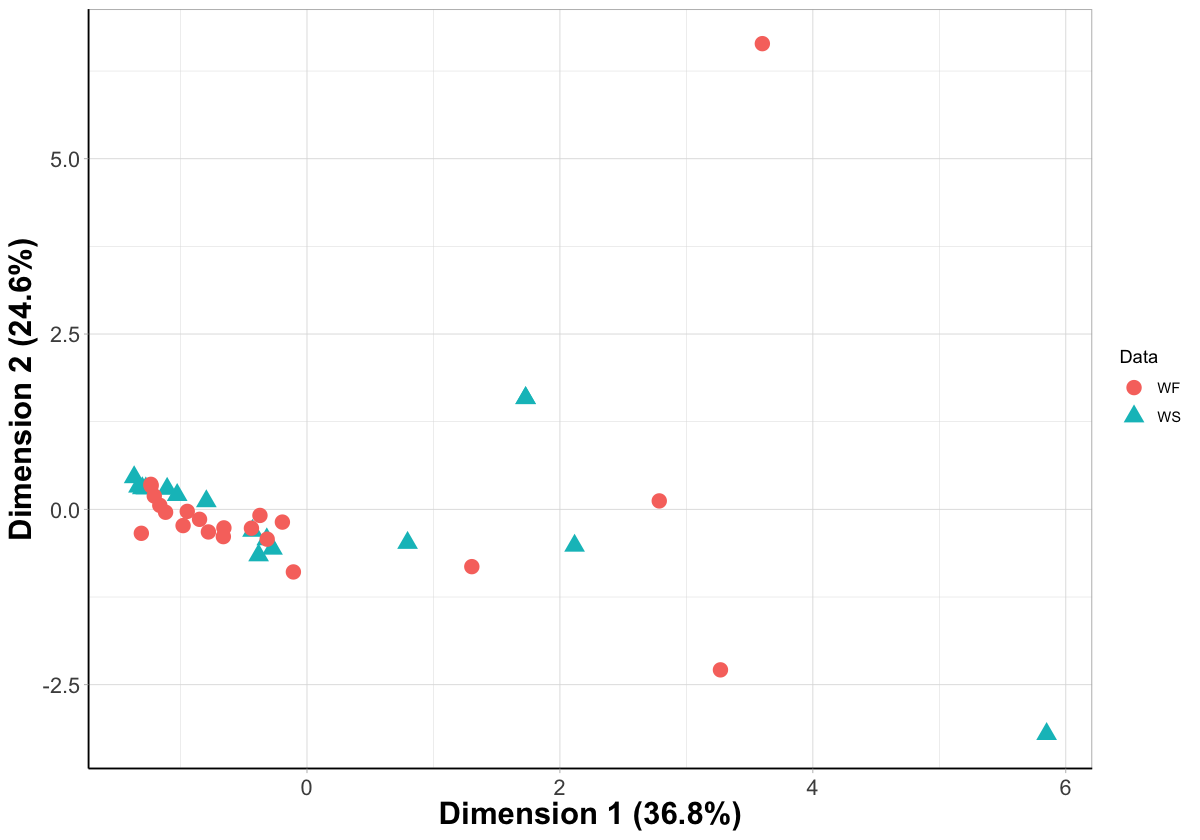

In [36]:
ggplot(data = full_eigenvector_df %>%
           filter(Metric == 'Weight', Chemical_Class == 'Metal'), 
       aes(x = PC1, y = PC2, color = Data, shape = Data)) + 
  geom_point(size = 4) + 

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 
  labs(x = 'Dimension 1 (36.8%)', y = 'Dimension 2 (24.6%)') #changing axis labels

# BCPA

In [4]:
bpca = pca(wider_metal_weight_df[,c(6:ncol(wider_metal_weight_df))], method = 'bpca', nPcs = 30)
bpca_scores <- data.frame(bpca@scores) 

Warning message in pca(wider_metal_weight_df[, c(6:ncol(wider_metal_weight_df))], :
“more components than matrix columns requested”


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


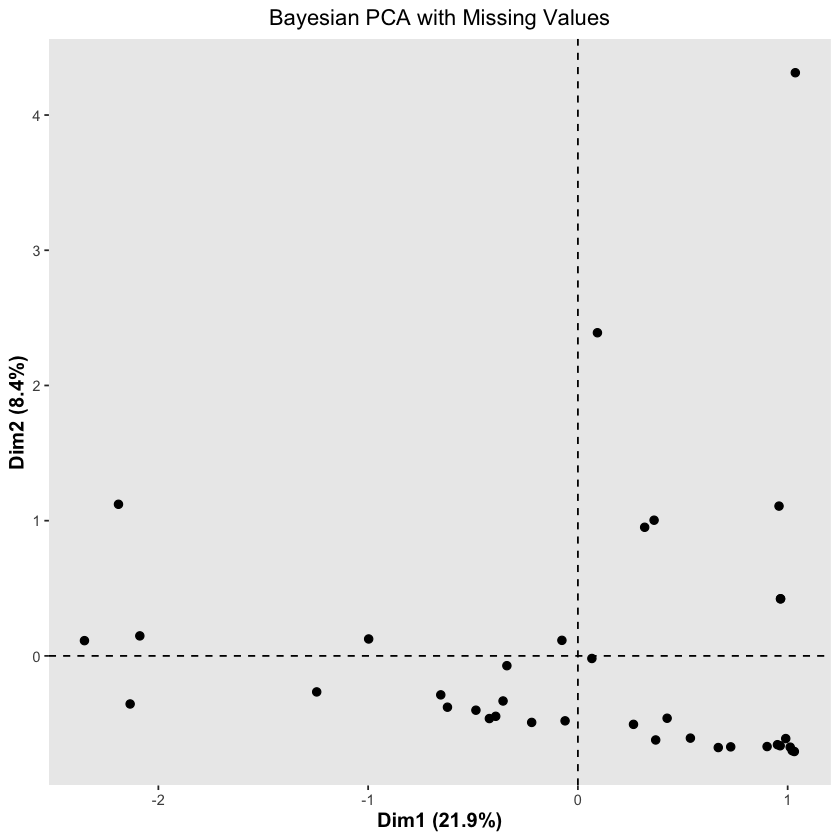

In [5]:
# Determine if there are any outliers > 6 SD from the mean
bpca_outliers <- apply(bpca_scores, 2, function(x) which( abs(x - mean(x)) > (6 * sd(x)) )) %>%
        Reduce(union, .)

# Get percentage contribution to each axis
bpca_loadings <- data.frame(bpca@R2)

# Make plot for supplement
bpca_plot <- ggplot(bpca_scores, aes(x = PC1, y = PC2)) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "black", size = 0.5) +
  geom_vline(xintercept = 0, linetype = "dashed", color = "black", size = 0.5) +
  geom_point(size = 2) +
  labs(x = "Dim1 (21.9%)", y = "Dim2 (8.4%)", title = "Bayesian PCA with Missing Values") +
  theme(panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        axis.title = element_text(face = "bold", size = rel(1.1)),
        plot.title = element_text(hjust = 0.5))

bpca_plot